In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-04 15:46:34.656238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 15:46:34.660827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 15:46:34.661141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-04 15:46:34.933162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 15:46:34.933855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 15:46:34.934217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 15:46:34.934512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 2.2519062e+00],
         [0.0000000e+00, 1.0573986e+00, 1.3442591e+00],
         [0.0000000e+00, 3.7037182e+00, 0.0000000e+00],
         ...,
         [8.4336996e-01, 0.0000000e+00, 0.0000000e+00],
         [5.5867189e-01, 3.9117715e-01, 1.0074273e+00],
         [2.3040218e+00, 0.0000000e+00, 4.3087749e+00]],

        [[0.0000000e+00, 1.4434991e+00, 0.0000000e+00],
         [0.0000000e+00, 1.1567098e+00, 3.4195188e-01],
         [0.0000000e+00, 8.9311272e-01, 7.9708952e-01],
         ...,
         [8.0042845e-01, 5.2078348e-01, 2.2649276e+00],
         [0.0000000e+00, 1.9855993e+00, 0.0000000e+00],
         [0.0000000e+00, 1.6502548e-02, 1.8905357e-01]],

        [[0.0000000e+00, 1.4170051e+00, 2.1864598e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 5.0197184e-01],


In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.0000000e+00, 0.0000000e+00, 2.2519062e+00],
          [0.0000000e+00, 1.0573986e+00, 1.3442591e+00],
          [0.0000000e+00, 3.7037182e+00, 0.0000000e+00],
          ...,
          [8.4336996e-01, 0.0000000e+00, 0.0000000e+00],
          [5.5867189e-01, 3.9117715e-01, 1.0074273e+00],
          [2.3040218e+00, 0.0000000e+00, 4.3087749e+00]],
 
         [[0.0000000e+00, 1.4434991e+00, 0.0000000e+00],
          [0.0000000e+00, 1.1567098e+00, 3.4195188e-01],
          [0.0000000e+00, 8.9311272e-01, 7.9708952e-01],
          ...,
          [8.0042845e-01, 5.2078348e-01, 2.2649276e+00],
          [0.0000000e+00, 1.9855993e+00, 0.0000000e+00],
          [0.0000000e+00, 1.6502548e-02, 1.8905357e-01]],
 
         [[0.0000000e+00, 1.4170051e+00, 2.1864598e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          ...,
          [0.0000000e+00, 

<IPython.core.display.Javascript object>


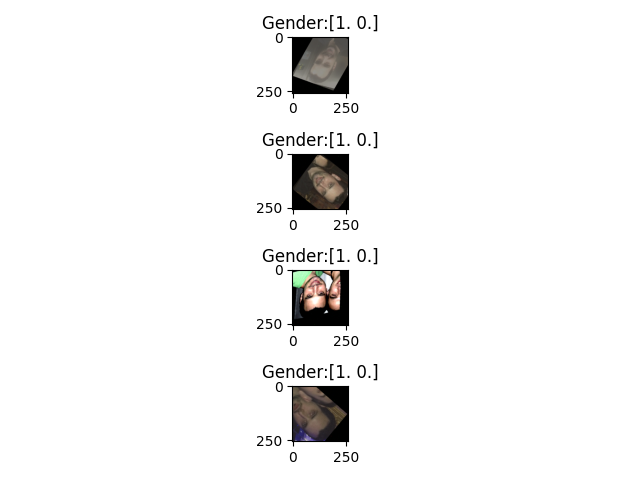

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=(4,4), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 5, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(256, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_13')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 64

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 64)           944000      ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_13"
logPrefix = "log"

In [48]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-04 15:47:00.498611: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-04 15:47:00.498635: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-04 15:47:00.498654: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-04 15:47:00.893686: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-04 15:47:00.894995: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


3528/3528 [==============================] - 14s 4ms/step - loss: 7721.3159 - gender_out_loss: 0.6922 - tf.math.multiply_1_loss: 5990.7305 - gender_out_accuracy: 0.5265
Epoch 1/300
   1/1000 [..............................] - ETA: 16:19 - loss: 9245.7588 - gender_out_loss: 0.6935 - tf.math.multiply_1_loss: 7511.9380 - gender_out_accuracy: 0.7500

2022-11-04 15:47:16.216072: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-04 15:47:16.216112: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 49s - loss: 9140.5654 - gender_out_loss: 0.6889 - tf.math.multiply_1_loss: 7418.2476 - gender_out_accuracy: 0.6000

2022-11-04 15:47:16.502864: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-04 15:47:16.503595: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-04 15:47:16.534200: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3107 callback api events and 3066 activity events. 
2022-11-04 15:47:16.557703: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-04 15:47:16.583256: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_13/log_0/plugins/profile/2022_11_04_15_47_16

2022-11-04 15:47:16.617599: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_13/log_0/plugins/profile/2022_11_04_15_47_16/rachanon-pc1.trace.json.gz
2022-11-04 15:47:16.651194: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 22s 22ms/step - loss: 4563.1387 - gender_out_loss: 0.6854 - tf.math.multiply_1_loss: 2849.6262 - gender_out_accuracy: 0.5623 - val_loss: 3978.4407 - val_gender_out_loss: 0.6805 - val_tf.math.multiply_1_loss: 2277.1260 - val_gender_out_accuracy: 0.5723
Epoch 2/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3331.5027 - gender_out_loss: 0.6572 - tf.math.multiply_1_loss: 1688.4359 - gender_out_accuracy: 0.6175 - val_loss: 3495.3574 - val_gender_out_loss: 0.6807 - val_tf.math.multiply_1_loss: 1793.4835 - val_gender_out_accuracy: 0.5727
Epoch 3/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3086.8528 - gender_out_loss: 0.6529 - tf.math.multiply_1_loss: 1454.6772 - gender_out_accuracy: 0.5925 - val_loss: 3300.6858 - val_gender_out_loss: 0.6804 - val_tf.math.multiply_1_loss: 1599.5854 - val_gender_out_accuracy: 0.5864
Epoch 4/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3022.3

1000/1000 [==============================] - 21s 21ms/step - loss: 2512.1084 - gender_out_loss: 0.6332 - tf.math.multiply_1_loss: 929.1138 - gender_out_accuracy: 0.6438 - val_loss: 2999.3572 - val_gender_out_loss: 0.7364 - val_tf.math.multiply_1_loss: 1158.3314 - val_gender_out_accuracy: 0.5437
Epoch 28/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2634.9082 - gender_out_loss: 0.6697 - tf.math.multiply_1_loss: 960.6025 - gender_out_accuracy: 0.5920 - val_loss: 2890.9199 - val_gender_out_loss: 0.6990 - val_tf.math.multiply_1_loss: 1143.3906 - val_gender_out_accuracy: 0.5401
Epoch 29/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2598.7612 - gender_out_loss: 0.6585 - tf.math.multiply_1_loss: 952.5339 - gender_out_accuracy: 0.6072 - val_loss: 2802.0854 - val_gender_out_loss: 0.6753 - val_tf.math.multiply_1_loss: 1113.7491 - val_gender_out_accuracy: 0.5750
Epoch 30/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2543.1

1000/1000 [==============================] - 21s 21ms/step - loss: 2545.6536 - gender_out_loss: 0.6606 - tf.math.multiply_1_loss: 894.1622 - gender_out_accuracy: 0.5947 - val_loss: 2735.3950 - val_gender_out_loss: 0.6726 - val_tf.math.multiply_1_loss: 1054.0107 - val_gender_out_accuracy: 0.5895
Epoch 54/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2469.5916 - gender_out_loss: 0.6426 - tf.math.multiply_1_loss: 862.9764 - gender_out_accuracy: 0.6313 - val_loss: 2804.4961 - val_gender_out_loss: 0.6712 - val_tf.math.multiply_1_loss: 1126.4124 - val_gender_out_accuracy: 0.5952
Epoch 55/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2486.8052 - gender_out_loss: 0.6430 - tf.math.multiply_1_loss: 879.3223 - gender_out_accuracy: 0.6400 - val_loss: 2701.2051 - val_gender_out_loss: 0.6616 - val_tf.math.multiply_1_loss: 1047.1326 - val_gender_out_accuracy: 0.5900
Epoch 56/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2440.9

1000/1000 [==============================] - 21s 21ms/step - loss: 2359.4763 - gender_out_loss: 0.6273 - tf.math.multiply_1_loss: 791.3432 - gender_out_accuracy: 0.6480 - val_loss: 2819.0442 - val_gender_out_loss: 0.7081 - val_tf.math.multiply_1_loss: 1048.7432 - val_gender_out_accuracy: 0.5622
Epoch 80/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2293.6396 - gender_out_loss: 0.5999 - tf.math.multiply_1_loss: 793.9399 - gender_out_accuracy: 0.6740 - val_loss: 2727.4419 - val_gender_out_loss: 0.6823 - val_tf.math.multiply_1_loss: 1021.7928 - val_gender_out_accuracy: 0.6014
Epoch 81/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2429.5618 - gender_out_loss: 0.6323 - tf.math.multiply_1_loss: 848.8827 - gender_out_accuracy: 0.6380 - val_loss: 2590.6362 - val_gender_out_loss: 0.6399 - val_tf.math.multiply_1_loss: 990.9912 - val_gender_out_accuracy: 0.6260
Epoch 82/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2377.80

Epoch 106/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2359.4712 - gender_out_loss: 0.6255 - tf.math.multiply_1_loss: 795.6851 - gender_out_accuracy: 0.6607 - val_loss: 2605.8525 - val_gender_out_loss: 0.6507 - val_tf.math.multiply_1_loss: 979.1478 - val_gender_out_accuracy: 0.6265
Epoch 107/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2233.1086 - gender_out_loss: 0.5773 - tf.math.multiply_1_loss: 789.9484 - gender_out_accuracy: 0.6925 - val_loss: 2552.5847 - val_gender_out_loss: 0.6269 - val_tf.math.multiply_1_loss: 985.3919 - val_gender_out_accuracy: 0.6572
Epoch 108/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2274.2717 - gender_out_loss: 0.5914 - tf.math.multiply_1_loss: 795.6760 - gender_out_accuracy: 0.6812 - val_loss: 2488.2400 - val_gender_out_loss: 0.6038 - val_tf.math.multiply_1_loss: 978.8199 - val_gender_out_accuracy: 0.6783
Epoch 109/300
1000/1000 [==============================] - 21s 21ms/step 

1000/1000 [==============================] - 21s 21ms/step - loss: 2119.8264 - gender_out_loss: 0.5431 - tf.math.multiply_1_loss: 762.1166 - gender_out_accuracy: 0.7228 - val_loss: 2411.9016 - val_gender_out_loss: 0.5746 - val_tf.math.multiply_1_loss: 975.4913 - val_gender_out_accuracy: 0.6948
Epoch 133/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2110.0225 - gender_out_loss: 0.5409 - tf.math.multiply_1_loss: 757.8743 - gender_out_accuracy: 0.7253 - val_loss: 2756.1467 - val_gender_out_loss: 0.6980 - val_tf.math.multiply_1_loss: 1011.1461 - val_gender_out_accuracy: 0.6386
Epoch 134/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2284.4741 - gender_out_loss: 0.5883 - tf.math.multiply_1_loss: 813.6790 - gender_out_accuracy: 0.6870 - val_loss: 2403.3081 - val_gender_out_loss: 0.5751 - val_tf.math.multiply_1_loss: 965.6627 - val_gender_out_accuracy: 0.6953
Epoch 135/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2193.

1000/1000 [==============================] - 21s 21ms/step - loss: 2146.7544 - gender_out_loss: 0.5529 - tf.math.multiply_1_loss: 764.4391 - gender_out_accuracy: 0.7172 - val_loss: 2576.1458 - val_gender_out_loss: 0.6362 - val_tf.math.multiply_1_loss: 985.5588 - val_gender_out_accuracy: 0.6478
Epoch 159/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2199.1943 - gender_out_loss: 0.5658 - tf.math.multiply_1_loss: 784.5916 - gender_out_accuracy: 0.6995 - val_loss: 2371.8599 - val_gender_out_loss: 0.5592 - val_tf.math.multiply_1_loss: 973.7990 - val_gender_out_accuracy: 0.7075
Epoch 160/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2054.5562 - gender_out_loss: 0.5100 - tf.math.multiply_1_loss: 779.6180 - gender_out_accuracy: 0.7565 - val_loss: 2542.3381 - val_gender_out_loss: 0.6269 - val_tf.math.multiply_1_loss: 975.0891 - val_gender_out_accuracy: 0.6853
Epoch 161/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2107.9

1000/1000 [==============================] - 21s 21ms/step - loss: 2071.2048 - gender_out_loss: 0.5105 - tf.math.multiply_1_loss: 795.0408 - gender_out_accuracy: 0.7502 - val_loss: 2483.3716 - val_gender_out_loss: 0.6062 - val_tf.math.multiply_1_loss: 967.7654 - val_gender_out_accuracy: 0.6812
Epoch 185/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2014.6913 - gender_out_loss: 0.4956 - tf.math.multiply_1_loss: 775.7178 - gender_out_accuracy: 0.7580 - val_loss: 2572.6919 - val_gender_out_loss: 0.6449 - val_tf.math.multiply_1_loss: 960.3318 - val_gender_out_accuracy: 0.6564
Epoch 186/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2001.6896 - gender_out_loss: 0.5008 - tf.math.multiply_1_loss: 749.8008 - gender_out_accuracy: 0.7517 - val_loss: 2354.4958 - val_gender_out_loss: 0.5569 - val_tf.math.multiply_1_loss: 962.1378 - val_gender_out_accuracy: 0.7255
Epoch 187/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2124.6

1000/1000 [==============================] - 21s 21ms/step - loss: 1960.4927 - gender_out_loss: 0.4768 - tf.math.multiply_1_loss: 768.6030 - gender_out_accuracy: 0.7745 - val_loss: 2499.7346 - val_gender_out_loss: 0.6144 - val_tf.math.multiply_1_loss: 963.8591 - val_gender_out_accuracy: 0.6871
Epoch 211/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2024.6803 - gender_out_loss: 0.5018 - tf.math.multiply_1_loss: 770.1576 - gender_out_accuracy: 0.7495 - val_loss: 2341.2542 - val_gender_out_loss: 0.5504 - val_tf.math.multiply_1_loss: 965.2258 - val_gender_out_accuracy: 0.7189
Epoch 212/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2040.7224 - gender_out_loss: 0.5007 - tf.math.multiply_1_loss: 789.0943 - gender_out_accuracy: 0.7610 - val_loss: 2655.7620 - val_gender_out_loss: 0.6788 - val_tf.math.multiply_1_loss: 958.8733 - val_gender_out_accuracy: 0.6579
Epoch 213/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1903.5

1000/1000 [==============================] - 21s 21ms/step - loss: 1947.4857 - gender_out_loss: 0.4687 - tf.math.multiply_1_loss: 775.8220 - gender_out_accuracy: 0.7717 - val_loss: 2230.4119 - val_gender_out_loss: 0.5084 - val_tf.math.multiply_1_loss: 959.4294 - val_gender_out_accuracy: 0.7540
Epoch 237/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1913.3184 - gender_out_loss: 0.4593 - tf.math.multiply_1_loss: 765.0048 - gender_out_accuracy: 0.7800 - val_loss: 2322.4746 - val_gender_out_loss: 0.5441 - val_tf.math.multiply_1_loss: 962.1922 - val_gender_out_accuracy: 0.7248
Epoch 238/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1909.6511 - gender_out_loss: 0.4596 - tf.math.multiply_1_loss: 760.7560 - gender_out_accuracy: 0.7865 - val_loss: 2282.9841 - val_gender_out_loss: 0.5312 - val_tf.math.multiply_1_loss: 954.9608 - val_gender_out_accuracy: 0.7305
Epoch 239/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1899.6

1000/1000 [==============================] - 21s 21ms/step - loss: 1842.3872 - gender_out_loss: 0.4288 - tf.math.multiply_1_loss: 770.3154 - gender_out_accuracy: 0.7965 - val_loss: 2080.3523 - val_gender_out_loss: 0.4521 - val_tf.math.multiply_1_loss: 949.9855 - val_gender_out_accuracy: 0.7857
Epoch 263/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1864.1885 - gender_out_loss: 0.4292 - tf.math.multiply_1_loss: 791.2745 - gender_out_accuracy: 0.8037 - val_loss: 2207.9875 - val_gender_out_loss: 0.5003 - val_tf.math.multiply_1_loss: 957.3162 - val_gender_out_accuracy: 0.7512
Epoch 264/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1914.4399 - gender_out_loss: 0.4552 - tf.math.multiply_1_loss: 776.4370 - gender_out_accuracy: 0.7800 - val_loss: 2211.0073 - val_gender_out_loss: 0.4980 - val_tf.math.multiply_1_loss: 966.0677 - val_gender_out_accuracy: 0.7499
Epoch 265/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1905.1

1000/1000 [==============================] - 21s 21ms/step - loss: 1849.1840 - gender_out_loss: 0.4404 - tf.math.multiply_1_loss: 748.1177 - gender_out_accuracy: 0.7908 - val_loss: 2696.5352 - val_gender_out_loss: 0.6979 - val_tf.math.multiply_1_loss: 951.9076 - val_gender_out_accuracy: 0.6437
Epoch 289/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1907.6061 - gender_out_loss: 0.4514 - tf.math.multiply_1_loss: 779.1325 - gender_out_accuracy: 0.7825 - val_loss: 2150.0173 - val_gender_out_loss: 0.4759 - val_tf.math.multiply_1_loss: 960.3848 - val_gender_out_accuracy: 0.7741
Epoch 290/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1791.9532 - gender_out_loss: 0.4131 - tf.math.multiply_1_loss: 759.2812 - gender_out_accuracy: 0.8077 - val_loss: 2020.5621 - val_gender_out_loss: 0.4297 - val_tf.math.multiply_1_loss: 946.2208 - val_gender_out_accuracy: 0.8001
Epoch 291/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1806.8

In [39]:
out = model(x)

2022-11-04 15:46:52.903233: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-04 15:46:53.659076: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [40]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[127.499535, 127.49941 , 127.499695],
          [127.50046 , 127.50012 , 127.50061 ],
          [127.49958 , 127.498695, 127.500275],
          ...,
          [127.50067 , 127.499054, 127.500534],
          [127.50087 , 127.499535, 127.49995 ],
          [127.50012 , 127.49957 , 127.499886]],
 
         [[127.50008 , 127.5002  , 127.500275],
          [127.499886, 127.500015, 127.49957 ],
          [127.499756, 127.499565, 127.501305],
          ...,
          [127.49849 , 127.49957 , 127.49965 ],
          [127.500916, 127.49881 , 127.50184 ],
          [127.49964 , 127.49992 , 127.49999 ]],
 
         [[127.50058 , 127.499985, 127.49833 ],
          [127.499725, 127.49951 , 127.4997  ],
          [127.49968 , 127.50067 , 127.50008 ],
          ...,
          [127.49984 , 127.498215, 127.500244],
          [127.50035 , 127.50072 , 127.49985 ],
          [127.500046, 127.499596, 127.499825]],
 
         ...,


<IPython.core.display.Javascript object>


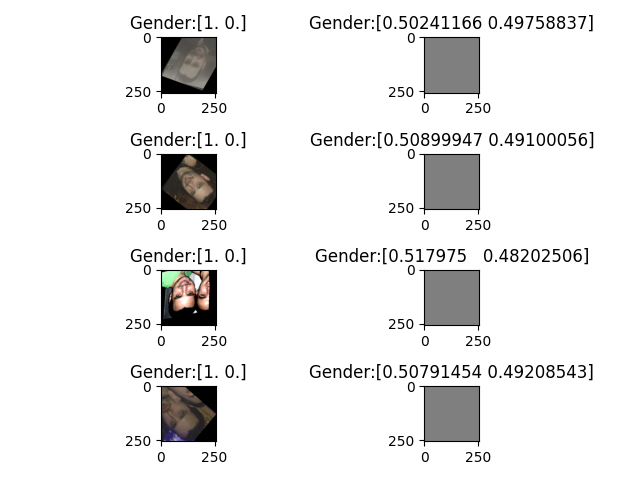

In [41]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [44]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [45]:
outTest = model(xTest)

In [46]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[127.49929 , 127.49923 , 127.49956 ],
          [127.500534, 127.50006 , 127.500626],
          [127.49939 , 127.4986  , 127.50021 ],
          ...,
          [127.49981 , 127.49855 , 127.50052 ],
          [127.49986 , 127.50026 , 127.50032 ],
          [127.50043 , 127.49966 , 127.49983 ]],
 
         [[127.499725, 127.50047 , 127.50011 ],
          [127.500015, 127.50009 , 127.49961 ],
          [127.49994 , 127.49914 , 127.50096 ],
          ...,
          [127.49921 , 127.49824 , 127.49826 ],
          [127.5017  , 127.49809 , 127.50096 ],
          [127.49941 , 127.4998  , 127.499916]],
 
         [[127.50041 , 127.49972 , 127.49814 ],
          [127.49986 , 127.49914 , 127.499466],
          [127.49997 , 127.500336, 127.49966 ],
          ...,
          [127.49907 , 127.49865 , 127.500984],
          [127.49979 , 127.4994  , 127.50011 ],
          [127.49964 , 127.49937 , 127.500275]],
 
         ...,


<IPython.core.display.Javascript object>


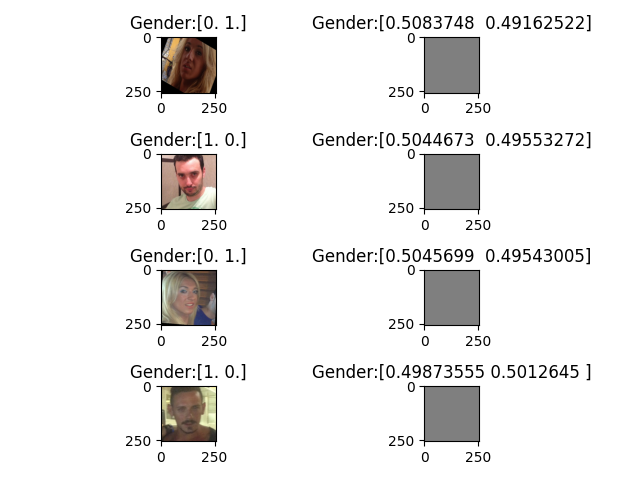

In [47]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()